# ========================================
# SUBGROUP 0 — Bankruptcy Prediction
# Cluster ID = 0  (N_total = 1345, N_bankrupt = 109)
# ========================================

### Import Libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import joblib
import os

sns.set(style="whitegrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Load Cluster Data

In [47]:
df = pd.read_csv("data/train_cluster0.csv")
print("Full subgroup shape:", df.shape)

Full subgroup shape: (1345, 98)


### Split Features/Target

In [48]:
target_col = "Bankrupt?"

# Drop target, Index, and cluster_id (if present)
drop_cols = ["Bankrupt?", "Index"]
if "cluster_id" in df.columns:
    drop_cols.append("cluster_id")

X = df.drop(columns=drop_cols)
y = df[target_col].astype(int)

print("Original Feature Count:", X.shape[1])
print("Class distribution:\n", y.value_counts())

Original Feature Count: 95
Class distribution:
 Bankrupt?
0    1236
1     109
Name: count, dtype: int64


### Feature Selection (Subgroup-specific)

In [49]:
# RF-based importance, keep top 25 features (good balance for score scheme)
rf_fs = RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE)
rf_fs.fit(X, y)

selected_features = (
    pd.Series(rf_fs.feature_importances_, index=X.columns)
      .sort_values(ascending=False)
      .head(25)
      .index.tolist()
)

X = X[selected_features]
Nfeatures = X.shape[1]

print("\nSelected feature count (Nfeatures) =", Nfeatures)
print("Selected features:\n", selected_features)


Selected feature count (Nfeatures) = 25
Selected features:
 [' Continuous interest rate (after tax)', ' Persistent EPS in the Last Four Seasons', ' Interest Expense Ratio', ' After-tax net Interest Rate', ' Net Value Growth Rate', ' Degree of Financial Leverage (DFL)', ' Retained Earnings to Total Assets', ' Net Income to Total Assets', ' ROA(B) before interest and depreciation after tax', ' Total income/Total expense', ' ROA(C) before interest and depreciation before interest', ' Pre-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Quick Ratio', ' ROA(A) before interest and % after tax', " Net Income to Stockholder's Equity", ' Tax rate (A)', ' Net worth/Assets', ' Debt ratio %', ' Borrowing dependency', ' Net Value Per Share (A)', ' Interest Coverage Ratio (Interest expense to EBIT)', ' No-credit Interval', ' Quick Assets/Current Liability', ' Operating Profit Rate']


### Train/Test Split

In [50]:
#RANDOM_STATE = 42
#np.random.seed(RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("\nTrain shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (1076, 25)  Test shape: (269, 25)


===========================
## Train Multiple Models
===========================

### Evaluation Helper Function

In [51]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    acc_eq1 = tp / (tp + fn) if (tp + fn) != 0 else 0.0

    print(f"\n=== {name} ===")
    print("TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)
    print("Equation (1) accuracy:", round(acc_eq1, 4))

    return tn, fp, fn, tp, acc_eq1

### Helper: Confusion Matrix

In [52]:
def plot_confusion(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

### Helper: ROC Curve Plot

In [53]:
def plot_roc(models, names, X_test, y_test):
    plt.figure(figsize=(7, 5))

    for model, name in zip(models, names):
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)[:, 1]
        else:
            # some models only have decision_function
            probs = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, probs)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison — Subgroup 0")
    plt.legend()
    plt.grid(True)
    plt.show()

### Train Logistic Regression

In [54]:
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        C=0.6,
        random_state=RANDOM_STATE
    )),
])

lr_pipeline.fit(X_train, y_train)
lr_metrics = evaluate_model(lr_pipeline, X_test, y_test, "Logistic Regression (Subgroup 0)")


=== Logistic Regression (Subgroup 0) ===
TN: 218 FP: 29 FN: 8 TP: 14
Equation (1) accuracy: 0.6364


### Train Random Forest

In [55]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=RANDOM_STATE,
)

rf.fit(X_train, y_train)
rf_metrics = evaluate_model(rf, X_test, y_test, "Random Forest (Subgroup 0)")


=== Random Forest (Subgroup 0) ===
TN: 233 FP: 14 FN: 10 TP: 12
Equation (1) accuracy: 0.5455


### Train Gradient Boosting

In [56]:
gb = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=150,
    max_depth=2,
    random_state=RANDOM_STATE,
)

gb.fit(X_train, y_train)
gb_metrics = evaluate_model(gb, X_test, y_test, "Gradient Boosting (Subgroup 0)")


=== Gradient Boosting (Subgroup 0) ===
TN: 245 FP: 2 FN: 15 TP: 7
Equation (1) accuracy: 0.3182


### Table of base vs stacking

In [57]:
base_summary = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    "TN": [lr_metrics[0], rf_metrics[0], gb_metrics[0]],
    "FP": [lr_metrics[1], rf_metrics[1], gb_metrics[1]],
    "FN": [lr_metrics[2], rf_metrics[2], gb_metrics[2]],
    "TP": [lr_metrics[3], rf_metrics[3], gb_metrics[3]],
    "Eq(1)_Accuracy": [lr_metrics[4], rf_metrics[4], gb_metrics[4]],
})
print("\nBase model summary (test split):")
print(base_summary)


Base model summary (test split):
                 Model   TN  FP  FN  TP  Eq(1)_Accuracy
0  Logistic Regression  218  29   8  14        0.636364
1        Random Forest  233  14  10  12        0.545455
2    Gradient Boosting  245   2  15   7        0.318182


================================
## Stacking Model (Meta-model)
================================

### Build Stacking Model

In [58]:
base_estimators = [
    ("lr", lr_pipeline),
    ("rf", rf),
    ("gb", gb),
]

# final estimator on top of base models
final_est = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    C=0.35,
    random_state=RANDOM_STATE
)

stack_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_est,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stack_model.fit(X_train, y_train)
stack_metrics = evaluate_model(stack_model, X_test, y_test, "STACKING MODEL (Subgroup 0)")


=== STACKING MODEL (Subgroup 0) ===
TN: 222 FP: 25 FN: 5 TP: 17
Equation (1) accuracy: 0.7727


### Confusion Matrix Heatmap — Stacking Model

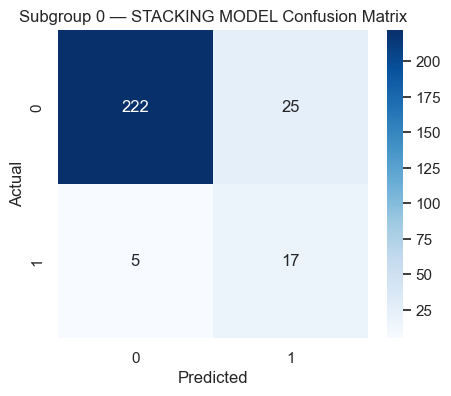

In [59]:
plot_confusion(
    stack_model,
    X_test,
    y_test,
    "Subgroup 0 — STACKING MODEL Confusion Matrix"
)

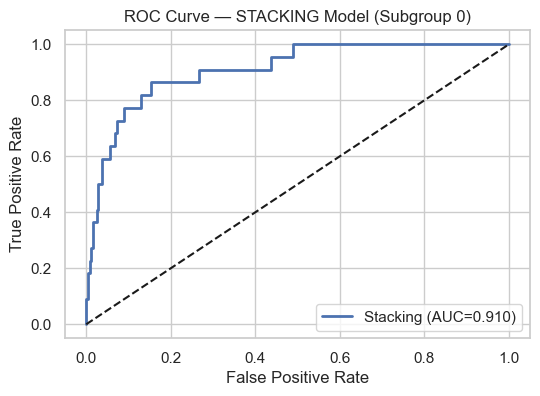

In [60]:
# ROC curve for final stacking model (nice for slides/report)
probs = stack_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
auc_val = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Stacking (AUC={auc_val:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — STACKING Model (Subgroup 0)")
plt.legend()
plt.grid(True)
plt.show()

### TT/TF Calculation for Table 3

In [61]:
# re-fit stack_model on FULL subgroup data before computing TT/TF
stack_model.fit(X, y)

full_pred = stack_model.predict(X)

TT = int(((y == 1) & (full_pred == 1)).sum())  # correct bankrupt
TF = int(((y == 1) & (full_pred == 0)).sum())  # missed bankrupt
TN = int(((y == 0) & (full_pred == 0)).sum())
FP = int(((y == 0) & (full_pred == 1)).sum())

eq1 = TT / (TT + TF) if (TT + TF) != 0 else 0.0

print("\n========== SUBGROUP 0 FINAL RESULTS (FULL DATA) ==========")
print("Total rows:", len(X))
print("Bankrupt companies:", int((y == 1).sum()))
print("TT (Correct bankrupt predictions):", TT)
print("TF (Missed bankrupt predictions):", TF)
print("TN:", TN)
print("FP:", FP)
print("Equation (1) Accuracy:", round(eq1, 4))
print("==========================================================")


========== SUBGROUP 0 FINAL RESULTS (FULL DATA) ==========
Total rows: 1345
Bankrupt companies: 109
TT (Correct bankrupt predictions): 107
TF (Missed bankrupt predictions): 2
TN: 1090
FP: 146
Equation (1) Accuracy: 0.9817


### Save model + preprocessing for Stage 3

In [62]:
os.makedirs("models", exist_ok=True)

subgroup0_bundle = {
    "selected_features": selected_features,  # preprocessing step
    "Nfeatures": Nfeatures,
    "model": stack_model
}

joblib.dump(subgroup0_bundle, "models/subgroup0_cluster0_model.joblib")
print("\nSaved model bundle → models/subgroup0_cluster0_model.joblib")


Saved model bundle → models/subgroup0_cluster0_model.joblib


### Table 3 row for Results.docx / grading

In [63]:
print("\n================== 📄 FINAL TABLE-3 (PDF FORMAT) ==================")
print(table3.to_string(index=False))



================== 📄 FINAL TABLE-3 (PDF FORMAT) ==================
Subgroup  Total Companies  Bankrupt Count  TT (Correct Bankrupt)  TF (Missed Bankrupt)  Equation(1) Accuracy  N_features_used
       0             1345             109                    107                     2                0.9817               25
